In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import pickle
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from tqdm import tqdm
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from sklearn.decomposition import PCA

from stardist import relabel_image_stardist3D, random_label_cmap
from stardist.matching import matching_dataset
from stardist.models import StarDist3D

from umdisto.utils import *

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Model structure

## Problem
We are given a training dataset of unannotated **aligned** worm images (as TIFF files e.g.) and want to segment and annotate all of them in one go in an unsupervised fashion.

## Data
We use 30 TIFF images of partly annotated worm images, i.e. each ground truth image of a worm comes with a ground truth (GT) label: its ground truth segmentation with semantic annotation. During training we will only use the images (unsupervised learning). We use the GT annotations only for evaluating our method.

## Method
1) **Instance segmentation:** Create an instance segmentation of each given image.
2) **Data cleaning:**
3) **Nuclei grouping:** Create groups of nuclei across worms where a group consists of nuclei (one per worm) that are "most similar", i.e. have similar relative position and shape. Those groups ideally represent nuclei that have the same ground truth annotation (which is not yet known as tha data is unlabeled).
4) **Induced annotation:** Choose a GT annotation of one (or multiple) worms in the training dataset. This annotation induces annotations across all other worms. Namely, by assigning the label X to each nucleus in the group that contains the nucleus with GT annotation X.
5) **Atlas creation:** All 30 worms together with their induces annotations can be used to form an atlas (i.e. statistical example worm).
6) **Evaluation:** We can compare the incuded annotation with the GT annotation of all other 29 worms. This way we can compute evaluation metrics and compare them with baseline models.
7) **Prediction:** Given a atlas created from a training dataset and an unseen worm image and we perform semantic segmentation of the new worm as follows: First create an instance segmentation as in (1), note that this step is modular and the method of nuclei instance segmentation can be varied. Then compute the nuclei group to which each segmented nucleus in the unseen worm most likely belongs to w.r.t. to the atlas. This induces an annotation of the segmented nuclei instances.

# 1. Instance segmentation

**Goal:** Given an input worm image this step produces an instance segmentation of the present nuclei.

This can be done using predictions of a pretrained instance segmentation model, e.g. StarDist. In case we do not use already available pretrained segmentation models we need to train an instance segmentation model from scratch. In that case we need additional "pretraining data", i.e. worm images (not present in the training dataset) and their corresponding instance segmentation masks.

<div class="alert alert-block alert-warning">
TODO:
Find a good instance segmentation model that performs well on the worm dataset and use the resulting segmentations. In case that model is StarDist we can use its feature reprentations in the next step.
</div>

In [2]:
DATA_PATH =  r"C:\Users\ckarg\Documents\Datasets\c_elegans\tiff\val"#os.path.join("worm_data", "val") # Should point to a path that contains "images" and "masks" folders with tiff files.
USE_MODEL = False # Use pretrained model to create a segmentation of input images, otherwise use segmentation masks from above path
MODEL_NAME = "stardist"

In [3]:
if USE_MODEL:
    # Load images
    X = sorted(glob(os.path.join(DATA_PATH,'images','*.tif')))
    X = list(map(imread,X))
    axis_norm = (0,1,2)   # normalize channels independently

    # Load model
    model = StarDist3D(None, name=MODEL_NAME, basedir='models')

    #Predict images
    instance_masks = []
    instance_details = []
    for i in range(len(X)):
        img = normalize(X[i], 1,99.8, axis=axis_norm)
        labels, details = model.predict_instances(img)
        instance_masks.append(labels)
        instance_details.append(details)

else: # Use segmentation masks
    # Load images
    Y = sorted(glob(os.path.join(DATA_PATH,'masks','*.tif')))
    Y = list(map(imread,Y))
    instance_masks = [np.array(y, dtype=int) for y in Y]
    instance_details = None

# 2. Feature extraction

**Given:** We have $N$ worm images $X_1,\dots,X_N$ and their corresponding instance segmentation masks $Y_1,\dots,Y_N$. Each mask $Y_i$ contains $n_i$ nuclei instances $P^i_1,\dots,P^i_{n_i}$ (ideally all $n_i$ are equal to 558, the number of cells in each c_elegans organism). We shortly write $P_{ij}$ for the set of all pixels forming nucleus instance $j=1,\dots,n_i$ in worm image $X_i$, and identify this set with the visible instance $P^i_j$.

**Goal:** To each pixel in an instance $P_{ij}$ we assign a vector "describing the position & geometry" of the instance that pixel is part of. The following features are extracted for each pixel of an instance:
1) the normalized distance to background of the pixel (= probability of center of the pixel)
2) the distances w.r.t. to a fixed set of directions
3) the position of the pixel
4) the vector from the worm centroid to the instance centroid

<div class="alert alert-block alert-warning">
TODO:
I am not sure if it is better to have different vectors for different pixels of an instance, or if it might be better to just have one set of features for the whole instance. In the first option the problem is that far away pixels of the same instance will have non-similar features which we do not want. In the second option the problem is that we might have too little information extracted from the whole instance.
</div>

**Method:** We have two possible options to extract those features:
1) *By computation:* Given an instance segmentation from any model we compute these features using explicit mathematical expressions.
2) *By prediction:* Given a raw worm image we can use the StarDist model directly to obtain an instance segmentation of the image, together with predictions of the above listed features.

Method (2) can be used if there is no good instance segmentation available and the StarDist model performs well on the given dataset, which needs to be tested first. If a GT instance segmentation is available or there are models that produce better segmentation results than StarDist then Method (1) should be used.


In [4]:
NUM_RAYS = 6 # Number of 3D rays to represent the shape of a nucleus instance; default: 64
USE_ANISOTROPY = True

In [5]:
ic = InstanceCollection(instance_masks, instance_details)

In [6]:
# Print centroid pixels of first few instances
for instance in list(ic.worms[0].instances.values())[:7]:
    print(instance.absolute_centroid)

[ 84.61407767  70.9538835  407.20995146]
[ 59.01151316  70.72697368 392.41447368]
[ 80.93368984  51.83315508 514.24064171]
[ 57.03832117  59.29014599 593.47810219]
[  73.84671533   62.45742092 1006.96350365]
[  62.89819005   59.58371041 1006.07692308]
[ 84.77714825  60.49197356 382.87157696]


In [7]:

# TODO: Retrieve ray data from instance
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores


Anisotropy of worm image: (1.6, 1.3333333333333333, 1.0)


Instance centroid: [ 84.61407767  70.9538835  407.20995146]
Centroid pixel: [ 85  71 407]
Ray distances from centroid: [6.        5.8309517 7.1414285 8.5440035 5.91608   4.       ]


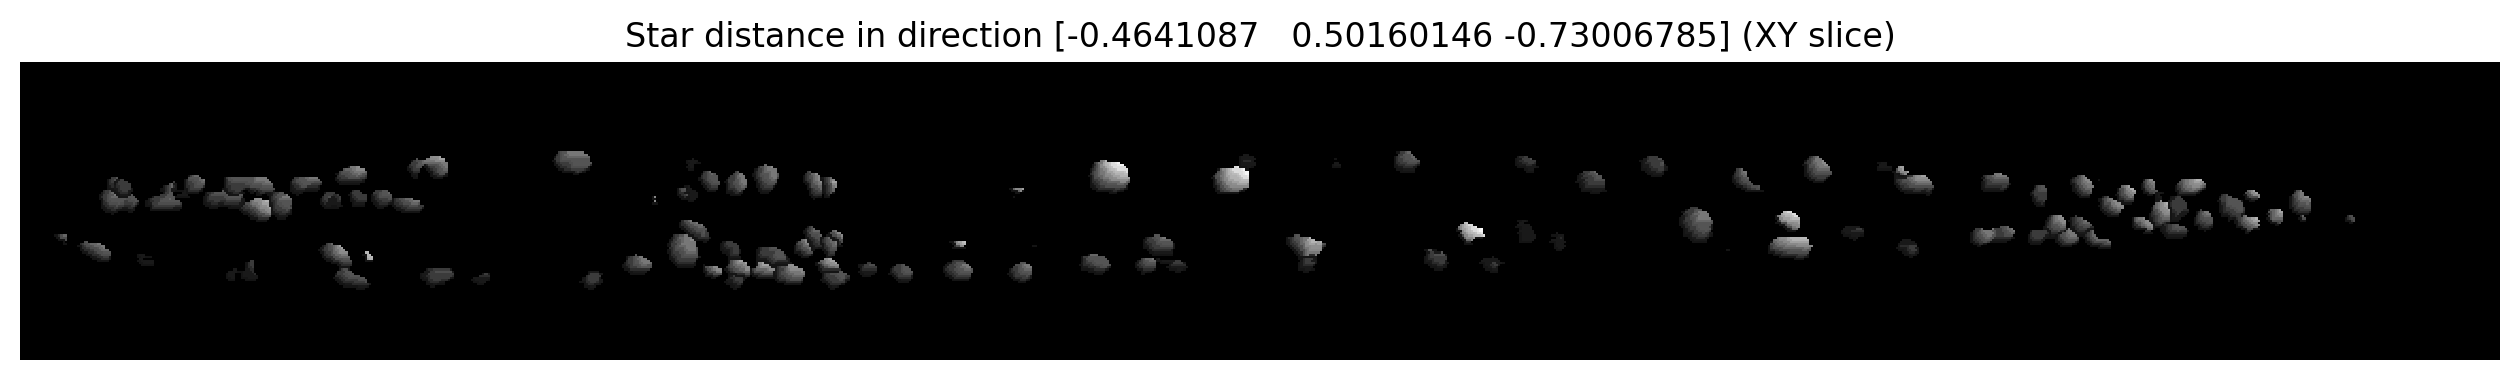

In [8]:
# Returns empirical anisotropy of labeled objects
def calculate_anisotropy(mask): 
    extents = calculate_extents(mask)
    anisotropy = tuple(np.max(extents) / extents)
    return anisotropy

# Pick test instance
test_worm_id = 0
test_worm = ic.worms[test_worm_id]
test_mask = test_worm.mask

instance_id = test_worm.instance_ids[0]
test_instance = test_worm.instances[(test_worm_id, instance_id)]

# Create rays based on empirical anisotropy
anisotropy = calculate_anisotropy(test_mask) if USE_ANISOTROPY else None
print(f"Anisotropy of worm image: {anisotropy}")
rays = Rays_GoldenSpiral(NUM_RAYS, anisotropy=anisotropy)

# Compute stardist array
star_dist_array = star_dist3D(test_mask, rays)

# Compute ray distances from centroid
centroid = np.round(test_instance.absolute_centroid).astype(int)
print(f"Instance centroid: {test_instance.absolute_centroid}")
print(f"Centroid pixel: {centroid}")
dist = star_dist_array[centroid[0], centroid[1], centroid[2], :]
print(f"Ray distances from centroid: {dist}")

# Plot distance per pixel in some direction (2d slice)
ray_idx = 1
dist_img = star_dist_array[:,:,:,ray_idx]
z = dist_img.shape[0] // 2

plt.figure(figsize=(16,10))
plt.imshow(dist_img[z],cmap='gray')
plt.axis('off')
plt.title(f'Star distance in direction {rays.vertices[ray_idx]} (XY slice)');

In [9]:
print(test_instance.bounding_min)
print(test_instance.bounding_max)
diam = test_instance.bounding_max - test_instance.bounding_min
print(diam)

[ 80  64 401]
[ 89  77 414]
[ 9 13 13]


In [10]:
features = InstanceFeatures(ic)
features.extract_features(NUM_RAYS, USE_ANISOTROPY)
representations = features.representations
list(representations.items())[:5]

Created instance representations (dim = 9) from:
- Relative centroids (dim = 3)
- Ray distances (dim = 6)


[((0, 5),
  array([  14.20035073,   -2.49790703, -122.13661698,    6.        ,
            6.55743837,    7.14142847,    7.8740077 ,    6.78233004,
            4.        ])),
 ((0, 6),
  array([ -11.40221378,   -2.72481684, -136.93209475,    5.        ,
            6.55743837,    5.19615221,    7.14142847,    4.47213602,
            5.        ])),
 ((0, 26),
  array([ 10.5199629 , -21.61863544, -15.10592672,   6.        ,
           6.55743837,   7.14142847,   7.14142847,   5.47722578,
           6.        ])),
 ((0, 27),
  array([-13.37540577, -14.16164454,  64.13153376,   5.        ,
           4.89897966,   6.16441393,   7.14142847,   5.47722578,
           5.        ])),
 ((0, 28),
  array([  3.43298839, -10.9943696 , 477.61693522,   4.        ,
           6.55743837,   5.19615221,   7.14142847,   4.47213602,
           5.        ]))]

(1026, 9)


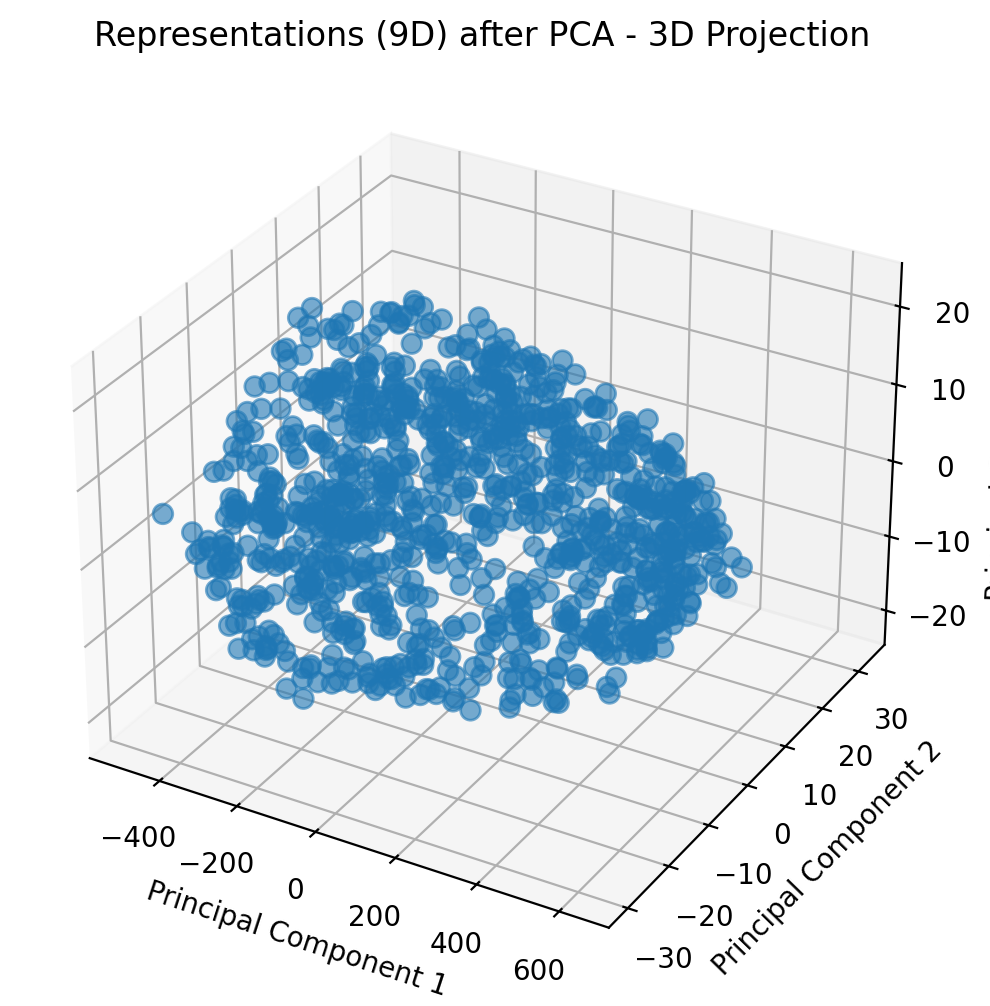

In [11]:
# Create a list of high-dimensional vectors (replace this with your data)
high_dimensional_data = np.array(list(features.representations.values())) 
print(high_dimensional_data.shape)

# Apply PCA to reduce dimensionality to 3 dimensions
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(high_dimensional_data)

# Plot the results in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], marker='o', s=50, alpha=0.6)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Representations (9D) after PCA - 3D Projection')

plt.show()

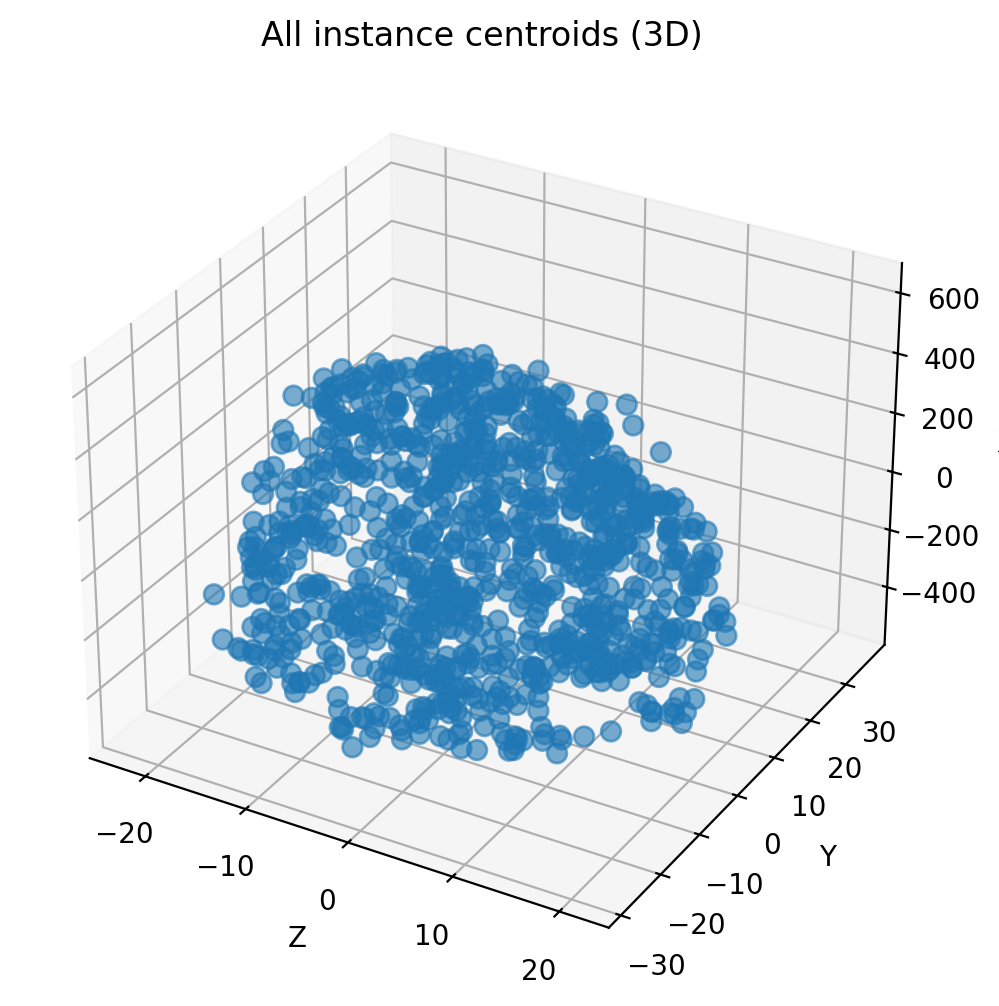

In [12]:
# Create a list of high-dimensional vectors (replace this with your data)
centroid_data = np.array(list(features.centroids.values())) 

# Plot the results in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(centroid_data[:, 0], centroid_data[:, 1], centroid_data[:, 2], marker='o', s=50, alpha=0.6)

ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_zlabel('X')
ax.set_title('All instance centroids (3D)')

plt.show()

# 3. Data cleaning

**Goal:** We have a a collection of ground truth images (tif format) and their corresponding instance segmentation masks (3d arrays with integer values: 0 for background pixels, each positive integer corresponding to one instance). These segmentation masks can either be obtained as a ground truth (manual anotations, for example) or as predictions from segmentation models. In this step we analyse the instance segmentation masks and test whether we have to dismiss some data.

The following will be analysed:
- Number of connected components of an instance. If it is greather than 1 we dismiss these instances from the dataset.
- The distances w.r.t. the stardist rays must not be 0.
- The centroid pixel of each instance should be a foreground pixel
- The diameter of an instance should not exceed a given threshold

In [13]:
DIAMETER_THRESHOLD = [50, 50, 90] # Intances with diameters larger than this will be declared "problematic".

In [14]:
def test_count_connected_components():
    # Example usage
    mask_3d = np.array([[[1, 10, 0], [0, 0, 2]], [[2, 2, 2], [0, 0, 1]]])  # Replace with your actual 3D mask array
    target_value = 1  # Replace with the value you want to count
    count = count_connected_components(mask_3d == target_value, target_value)
    assert count == 2

test_count_connected_components()

In [15]:
problem_summary = features.analyse_features(DIAMETER_THRESHOLD)
problem_instances = list(problem_summary.keys())

100%|██████████| 1026/1026 [02:58<00:00,  5.73it/s]

Number of problematic instances: 32
Summary has been saved to problem_log.txt.


## Some problematic instance examples

(140, 140, 1166)


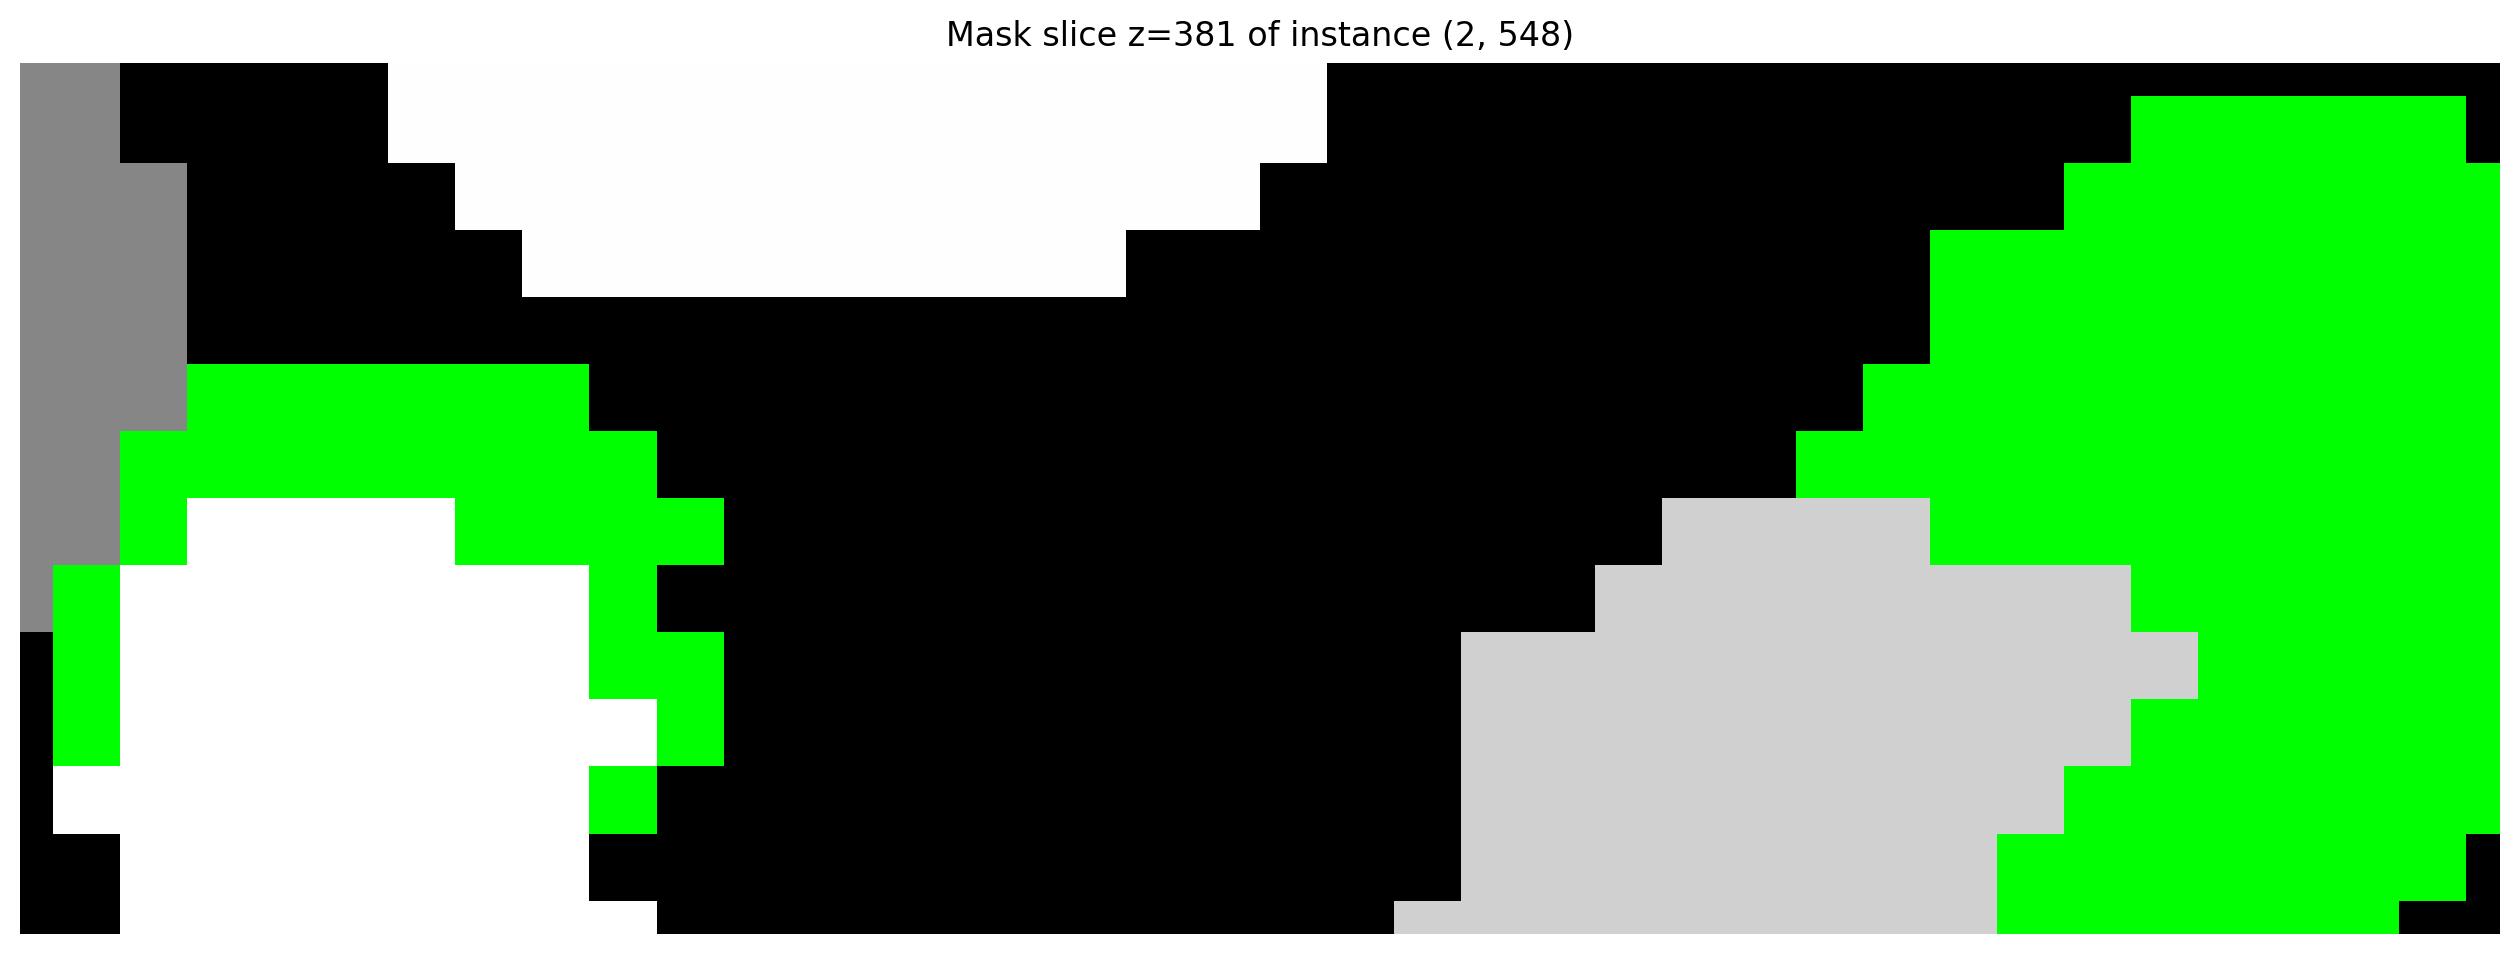

In [5]:
worm_id = 2
instance_id = 548
z_slice = 381
ic.plot_instance_slice(worm_id, instance_id, z_slice)

In [23]:
ic.plot_instance(2, 548)


Worm ID: 2, Instance ID: 548, Shape: (17, 41, 21)

<img src="3d_array_slices_32602.gif" width="750" align="center">

In [7]:
fail_index = 24

worm_id = problem_instances[fail_index][0]
instance_id = problem_instances[fail_index][1]
ic.plot_instance(worm_id, instance_id)

NameError: name 'problem_instances' is not defined

In [24]:
ic.plot_instance(2, 407)

Worm ID: 2, Instance ID: 407, Shape: (22, 26, 55)

<img src="3d_array_slices_47071.gif" width="750" align="center">

## Creating the cleaned instance collection

In [20]:
cleaned_ic = ic.clean_collection(problem_instances)
cleaned_features = InstanceFeatures(cleaned_ic)
cleaned_features.extract_features(NUM_RAYS, USE_ANISOTROPY)
cleaned_features.analyse_features(DIAMETER_THRESHOLD)


Created instance representations (dim = 9) from:
- Relative centroids (dim = 3)
- Ray distances (dim = 6)


100%|██████████| 994/994 [03:01<00:00,  5.48it/s]


{}

Store all variables in pickle file

In [54]:
# Assume `result` is a dictionary containing all the variables you want to save
pickle_vars = {
    'ic': ic,
    'cleaned_ic': cleaned_ic,
    'features': features,
    'cleaned_features': cleaned_features
}

# Save the result to a file using pickle
with open(r'C:\Users\ckarg\Documents\Datasets\stardist\saved_data.pkl', 'wb') as f:
    pickle.dump(pickle_vars, f)


# 4. Nuclei Grouping

**Given:** For every instance $P$ in every segmentation masks we have generated a feature representation $v_P$ in form of a high-dimensional array that describes the position and shape of that instance.

**Goal:** We want to find a transformation that moves alle feature vectors $v_p$ in such a way that a we can identify clusters.
Mainly, instances of similiar position an shape are mapped to similiar feature vectors. Whereas instances of the same worm should be mapped to distinct vectors. This way, similar instances across all worms form dense vector clusters which represent the nuclei groups. Ideally, each such cluster contains $n\_worms$ feature vectors, namely one instance per worm. 

**Method:** Based on shape and position representations we use metric learning to transform the representaions using a metric loss:
- Instances whose position vectors are almost equal are pushed together, pulled apart otherwise (equal in terms of angle and length)
- Instances whose shape vectors are almost equal are pushed together, pulled apart otherwise (equal in terms of L2 loss (?))
- Instances belonging to the same worm are pushed apart

### Loss ideas

1) Contrastive loss:
- Positive samples: For each instance $P$ the 29 most similar instances $Q$ are positive pairs $(P,Q)$.
- Negative samples: For each instance $P$ the ~500 same-worm instances $Q$ are negative pairs $(P,Q)$.

BUT: What does "closest" instances mean? With respect to which metric? Simple Euclidean? Or weighted by covariances (Mahalanobis distance)?

Load all variables from pickle file

In [4]:
# Load the saved data from the file
with open(r'C:\Users\ckarg\Documents\Datasets\stardist\saved_data.pkl', 'rb') as f:
    loaded_result = pickle.load(f)

# Access the variables
ic = loaded_result['ic']
cleaned_ic = loaded_result['cleaned_ic']
features = loaded_result['features']
cleaned_features = loaded_result['cleaned_features']


### Observations

Given all (cleaned) instances we want to check:
- How many instances are close to a given instance
- the covariances of the representations


In [5]:
cleaned_representations = cleaned_features.representations
rep_count = len(cleaned_representations)
print(f"Number of instance representations: {rep_count}")
instance_ids = list(cleaned_representations.keys())
rep_array = np.array(list(cleaned_representations.values())) # Nx9 array

# 9x9 Covariance matrix of representations
# We have N 9D representations, we store each rep in one row, so a Nx9 
assert rep_array.shape == (rep_count, 9)
cov = np.cov(rep_array.T)
assert cov.shape == (9, 9)
assert np.linalg.det(cov) > 0.001
cov_inv = np.linalg.inv(cov)

def instance_dist(id_1, id_2):
    return np.linalg.norm(cleaned_representations[id_1] - cleaned_representations[id_2])

def instance_mahalanobis_dist(id_1, id_2, cov_inv):
    diff = np.array(cleaned_representations[id_1] - cleaned_representations[id_2])
    return np.sqrt(diff @ cov_inv @ diff.T)

# Pairwise distance matrix
dist_mat = np.zeros((len(cleaned_representations), len(cleaned_representations)))
mahalanobis_mat = np.zeros((len(cleaned_representations), len(cleaned_representations)))
for i, id_1 in enumerate(tqdm(cleaned_representations.keys())):
    for j, id_2 in enumerate(cleaned_representations.keys()):
        if i == j:
            dist_mat[i, j] = 0
            mahalanobis_mat[i,j] = 0
        if i < j:
            dist_mat[i, j] = instance_dist(id_1, id_2)
            dist_mat[j, i] = dist_mat[i, j]
            mahalanobis_mat[i,j] = instance_mahalanobis_dist(id_1, id_2, cov_inv)
            mahalanobis_mat[j,i] = mahalanobis_mat[i,j]
assert dist_mat.shape == (rep_count, rep_count)


Number of instance representations: 994


100%|██████████| 994/994 [00:06<00:00, 151.63it/s]


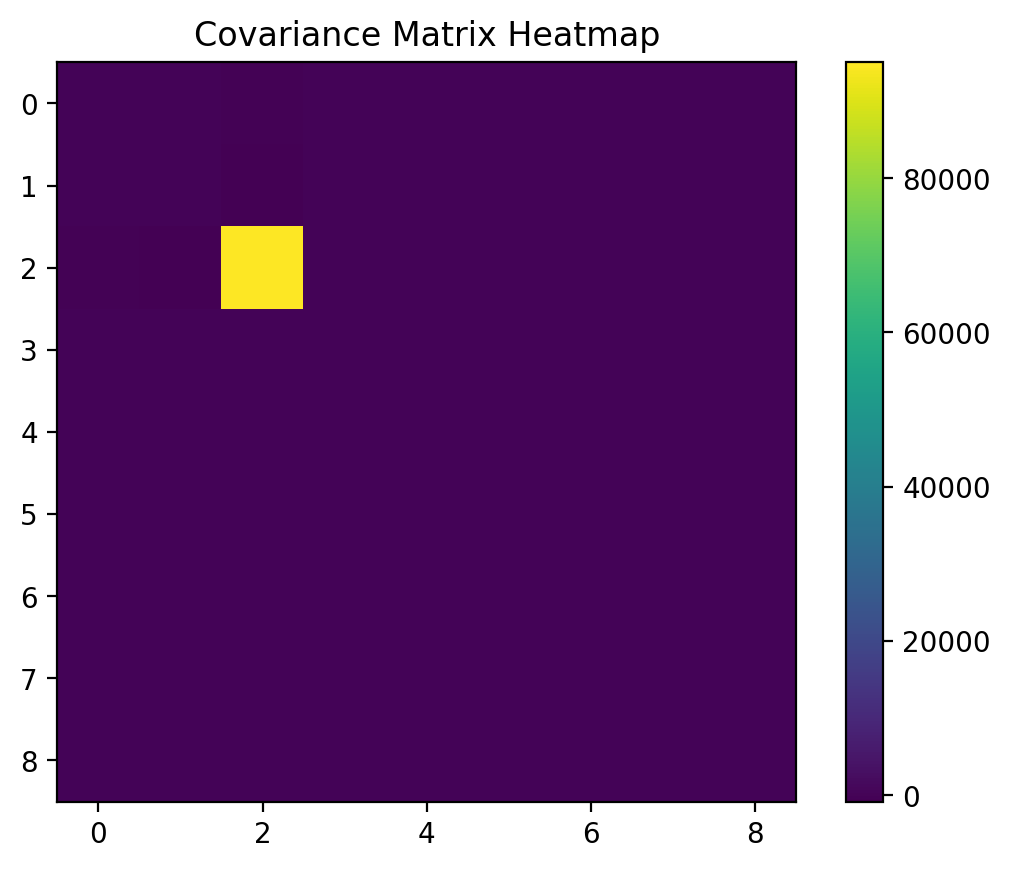

array([[ 9.02692957e+01,  1.46767795e+01, -1.19111465e+02,
        -1.09521102e-01,  9.00311384e-01,  3.94130561e-02,
        -6.61945137e-02,  1.61766614e+00, -1.90592721e-01],
       [ 1.46767795e+01,  2.19454229e+02, -8.24725202e+02,
         7.73723206e-01,  2.45103300e+00, -7.77670073e-01,
        -3.98498382e-01,  1.35048214e+00,  3.58520625e-01],
       [-1.19111465e+02, -8.24725202e+02,  9.50273108e+04,
         4.23609388e+01,  6.22369893e+01,  7.15980167e+01,
         6.38730641e+01,  1.71919677e+01,  5.67734068e+01],
       [-1.09521102e-01,  7.73723206e-01,  4.23609388e+01,
         1.26064443e+00,  6.39865593e-01,  4.52200759e-01,
         4.61758085e-01,  3.77507236e-01,  7.41785051e-01],
       [ 9.00311384e-01,  2.45103300e+00,  6.22369893e+01,
         6.39865593e-01,  1.92084109e+00,  6.00016499e-01,
         7.46537903e-01,  8.80118577e-01,  5.55567711e-01],
       [ 3.94130561e-02, -7.77670073e-01,  7.15980167e+01,
         4.52200759e-01,  6.00016499e-01,  1.732943

In [6]:
# Plot the covariance matrix as a heatmap
plt.imshow(cov, cmap='viridis', interpolation='nearest')
plt.title('Covariance Matrix Heatmap')
plt.colorbar()
plt.show()
cov

In [7]:
IDX = 44 # index of reference instance

ref_instance = instance_ids[IDX]
ref_representation = cleaned_representations[ref_instance]

k = cleaned_ic.num_worms

# Find K closest instances to the reference instance
closest_indices = np.argsort(mahalanobis_mat[IDX,:])[:k+1]
# Get the K closest vectors
closest_vectors = [rep_array[i,:] for i in closest_indices]
closest_instances = [instance_ids[i] for i in closest_indices]
assert closest_instances[0] == ref_instance
print(f"The {k} closest instances to instance {ref_instance} (after itself) are: {closest_instances}")


The 3 closest instances to instance (0, 125) (after itself) are: [(0, 125), (1, 517), (2, 208), (0, 448)]


In [17]:
def neighbors_of(instance, k):
    idx = instance_ids.index(instance)
    # Find K closest instances to the reference instance
    closest_indices = np.argsort(mahalanobis_mat[idx,:])[:k+1]
    # Get the K closest vectors
    closest_instances = [instance_ids[i] for i in closest_indices]
    #assert closest_instances[0] == ref_instance
    print(f"The {k} closest instances to instance {instance} (after itself) are: {closest_instances}")
    for i in range(k+1):
        print(f"Distance to {closest_instances[i]}: {mahalanobis_mat[idx, closest_indices[i]]}")

neighbors_of((2, 208), 6)

The 6 closest instances to instance (2, 208) (after itself) are: [(2, 208), (2, 209), (1, 208), (1, 517), (1, 360), (1, 554), (0, 125)]
Distance to (2, 208): 0.0
Distance to (2, 209): 0.9506849287743664
Distance to (1, 208): 0.9844238198116203
Distance to (1, 517): 1.0972062321917004
Distance to (1, 360): 1.2064056796393068
Distance to (1, 554): 1.3429912460485192
Distance to (0, 125): 1.3761407327649946


### Ideas:
1) Learn "better" features by training a Unet taking as inputs bounding boxes of nuclei and regenerating those patches.
2) Create a naive coupling approach by nearest features (w.r.t. to Mahalanobis distance). For each nucleus collect all closest nuclei per worm and see which pairs intersect. Name "clique" the maximal occuring pair group across all worms. The bigger the clique the higher the chance of those nuclei corresponding.
3) Plot a worm and its nuclei according to clique size / etc
4) Test metric learning on hand-picked 

### TODOs:
- Create a dataset train/test by generating a fixed size boudning box of each nucleus across all worms. This should be used as input in a replicating U-Net structure. The bottle neck might contain good candidates for features representing the cells. These might turn out better than hand-picked features

In [21]:
# Create dict of closest neighbors in distinct worms per instance
closest_neighbors = {}

for instance in instance_ids:
    result = []
    idx = instance_ids.index(instance)
    worm_id = instance[0]
    closest_indices = np.argsort(mahalanobis_mat[idx,:])
    closest_instances = [instance_ids[i] for i in closest_indices]

    num_worms = cleaned_ic.num_worms
    collected_ids = set([worm_id])
    for candidate in closest_instances:
        if candidate[0] not in collected_ids:
            collected_ids.add(candidate[0])
            result.append(candidate)
        if len(collected_ids)==num_worms:
            break

    closest_neighbors[instance] = result


def collect_closest_instances():
    closest_neighbors = {}
    for instance in instance_ids:
        result = []
        idx = instance_ids.index(instance)
        worm_id = instance[0]
        closest_indices = np.argsort(mahalanobis_mat[idx,:])
        closest_instances = [instance_ids[i] for i in closest_indices]

        num_worms = cleaned_ic.num_worms
        collected_ids = set([worm_id])
        for candidate in closest_instances:
            if candidate[0] not in collected_ids:
                collected_ids.add(candidate[0])
                result.append(candidate)
            if len(collected_ids)==num_worms:
                break

        closest_neighbors[instance] = result
    return closest_neighbors


In [22]:
collect_closest_instances()

{(0, 5): [(2, 5), (1, 371)],
 (0, 6): [(1, 281), (2, 438)],
 (0, 26): [(2, 291), (1, 82)],
 (0, 27): [(2, 145), (1, 83)],
 (0, 28): [(1, 518), (2, 458)],
 (0, 29): [(1, 517), (2, 265)],
 (0, 30): [(2, 191), (1, 252)],
 (0, 31): [(2, 312), (1, 158)],
 (0, 40): [(1, 212), (2, 178)],
 (0, 41): [(1, 158), (2, 271)],
 (0, 42): [(2, 551), (1, 498)],
 (0, 65): [(2, 142), (1, 176)],
 (0, 79): [(1, 392), (2, 164)],
 (0, 82): [(1, 26), (2, 437)],
 (0, 83): [(2, 87), (1, 83)],
 (0, 84): [(1, 84), (2, 30)],
 (0, 85): [(2, 83), (1, 269)],
 (0, 86): [(1, 86), (2, 162)],
 (0, 87): [(2, 87), (1, 147)],
 (0, 88): [(2, 445), (1, 88)],
 (0, 89): [(2, 351), (1, 400)],
 (0, 102): [(1, 498), (2, 497)],
 (0, 103): [(1, 147), (2, 113)],
 (0, 104): [(2, 115), (1, 103)],
 (0, 105): [(1, 105), (2, 104)],
 (0, 106): [(1, 121), (2, 117)],
 (0, 107): [(1, 121), (2, 121)],
 (0, 108): [(1, 121), (2, 117)],
 (0, 109): [(2, 195), (1, 208)],
 (0, 110): [(1, 517), (2, 195)],
 (0, 111): [(2, 42), (1, 498)],
 (0, 112): [(1

### IDEA: Create touch graph of instances

In [46]:
'''
Returns true if the masks contains two neighboring pixels that have value id_1 and id_2.
'''
def do_instances_touch(id_1, id_2, mask):
    id_1_coordinates, id_2_coordinates = [], []
    for i, row in enumerate(mask):
        for j, sublist in enumerate(row):
            for k, value in enumerate(sublist):
                if value == id_1:
                    id_1_coordinates.append((i, j, k))
                if value == id_2:
                    id_2_coordinates.append((i,j,k))
    print(id_1_coordinates)
    return do_touch(id_1_coordinates, id_2_coordinates)

def do_touch(pixels_1, pixels_2, diagonal=False):
    pixels_1_set = set(pixels_1)
    if not diagonal:
        offset_pixel_2 = [(pixel[0] + dx, pixel[1] + dy, pixel[2] + dz) for pixel in pixels_2 for dx, dy, dz in [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]]
    return not pixels_1_set.isdisjoint(set(offset_pixel_2))

def are_close(id_1, id_2, worm, threshold):
    instance_1 = worm.instances[(worm.worm_id, id_1)]
    instance_2 = worm.instances[(worm.worm_id, id_2)]
    offset = instance_1.absolute_centroid - instance_2.relative_centroid
    return True if np.linalg.norm(offset) <= threshold else False

In [47]:
# For each mask create a graph G with vertices V for each instance and edges E between two instances if both instances touch in the mask, i.e. have neighboring pixels.
import igraph as ig

IDX = 0
PROXIMITY_THRESHOLD = 70
worm = cleaned_ic.worms[IDX]
mask = worm.mask
instances = list(worm.instances.keys())

result = []
close_count = 0
for instance_1 in tqdm(instances):
    for instance_2 in instances:
        if instance_1[1] < instance_2[1]:
            if are_close(instance_1[1], instance_2[1], worm, PROXIMITY_THRESHOLD):
                close_count += 1
                touch = do_instances_touch(instance_1[1], instance_2[1], mask)
            else:
                touch = False
            if touch:
                result.append((instance_1[1], instance_2[1]))

  0%|          | 0/341 [00:00<?, ?it/s]

[(48, 55, 355), (48, 55, 356), (48, 55, 357), (48, 55, 358), (48, 57, 356), (48, 57, 357), (48, 57, 358), (48, 58, 357), (48, 58, 358), (49, 54, 355), (49, 54, 356), (49, 54, 357), (49, 54, 358), (49, 54, 359), (49, 55, 354), (49, 55, 355), (49, 55, 356), (49, 55, 357), (49, 55, 358), (49, 55, 359), (49, 55, 360), (49, 55, 361), (49, 56, 354), (49, 56, 355), (49, 56, 356), (49, 56, 357), (49, 56, 358), (49, 56, 359), (49, 56, 360), (49, 56, 361), (49, 56, 362), (49, 56, 363), (49, 57, 355), (49, 57, 356), (49, 57, 357), (49, 57, 358), (49, 57, 359), (49, 57, 360), (49, 57, 361), (49, 58, 354), (49, 58, 355), (49, 58, 356), (49, 58, 357), (49, 58, 358), (49, 58, 359), (49, 58, 360), (49, 58, 361), (49, 58, 362), (49, 59, 355), (49, 59, 356), (49, 59, 357), (49, 59, 358), (49, 59, 359), (49, 59, 360), (49, 59, 361), (49, 59, 362), (49, 59, 363), (50, 53, 354), (50, 53, 355), (50, 53, 356), (50, 53, 357), (50, 53, 358), (50, 53, 359), (50, 53, 360), (50, 54, 353), (50, 54, 354), (50, 54, 

  2%|▏         | 8/341 [00:11<07:51,  1.42s/it]

[(48, 55, 355), (48, 55, 356), (48, 55, 357), (48, 55, 358), (48, 57, 356), (48, 57, 357), (48, 57, 358), (48, 58, 357), (48, 58, 358), (49, 54, 355), (49, 54, 356), (49, 54, 357), (49, 54, 358), (49, 54, 359), (49, 55, 354), (49, 55, 355), (49, 55, 356), (49, 55, 357), (49, 55, 358), (49, 55, 359), (49, 55, 360), (49, 55, 361), (49, 56, 354), (49, 56, 355), (49, 56, 356), (49, 56, 357), (49, 56, 358), (49, 56, 359), (49, 56, 360), (49, 56, 361), (49, 56, 362), (49, 56, 363), (49, 57, 355), (49, 57, 356), (49, 57, 357), (49, 57, 358), (49, 57, 359), (49, 57, 360), (49, 57, 361), (49, 58, 354), (49, 58, 355), (49, 58, 356), (49, 58, 357), (49, 58, 358), (49, 58, 359), (49, 58, 360), (49, 58, 361), (49, 58, 362), (49, 59, 355), (49, 59, 356), (49, 59, 357), (49, 59, 358), (49, 59, 359), (49, 59, 360), (49, 59, 361), (49, 59, 362), (49, 59, 363), (50, 53, 354), (50, 53, 355), (50, 53, 356), (50, 53, 357), (50, 53, 358), (50, 53, 359), (50, 53, 360), (50, 54, 353), (50, 54, 354), (50, 54, 

 22%|██▏       | 75/341 [00:20<01:02,  4.29it/s]

[(61, 52, 3), (61, 52, 4), (61, 52, 5), (61, 53, 4), (61, 53, 5), (61, 54, 3), (61, 54, 4), (61, 54, 5), (61, 54, 6), (61, 54, 7), (61, 55, 3), (61, 55, 4), (61, 55, 5), (61, 55, 6), (61, 55, 7), (62, 51, 3), (62, 51, 4), (62, 51, 5), (62, 52, 1), (62, 52, 2), (62, 52, 3), (62, 52, 4), (62, 52, 5), (62, 52, 6), (62, 52, 7), (62, 53, 1), (62, 53, 2), (62, 53, 3), (62, 53, 4), (62, 53, 5), (62, 53, 6), (62, 53, 7), (62, 53, 8), (62, 54, 2), (62, 54, 3), (62, 54, 4), (62, 54, 5), (62, 54, 6), (62, 54, 7), (62, 54, 8), (62, 54, 9), (62, 55, 3), (62, 55, 4), (62, 55, 5), (62, 55, 6), (62, 55, 7), (62, 55, 8), (62, 55, 9), (62, 55, 10), (62, 56, 3), (62, 56, 4), (62, 56, 5), (62, 56, 6), (62, 56, 7), (62, 56, 8), (62, 56, 9), (62, 56, 10), (62, 57, 5), (62, 57, 6), (62, 57, 7), (62, 57, 8), (62, 57, 9), (62, 57, 10), (63, 50, 2), (63, 50, 3), (63, 50, 4), (63, 50, 5), (63, 50, 6), (63, 51, 2), (63, 51, 3), (63, 51, 4), (63, 51, 5), (63, 51, 6), (63, 51, 7), (63, 51, 8), (63, 52, 1), (63, 52,

 54%|█████▍    | 185/341 [00:23<00:14, 10.99it/s]

[(56, 61, 106), (56, 61, 107), (56, 62, 104), (56, 62, 105), (56, 62, 106), (56, 62, 107), (56, 62, 108), (56, 62, 109), (56, 62, 110), (56, 62, 111), (56, 63, 104), (56, 63, 105), (56, 63, 106), (56, 63, 107), (56, 63, 108), (56, 63, 109), (56, 63, 110), (56, 63, 111), (56, 63, 112), (56, 64, 106), (56, 64, 107), (56, 64, 108), (56, 64, 109), (57, 60, 105), (57, 60, 106), (57, 60, 107), (57, 60, 108), (57, 60, 109), (57, 60, 110), (57, 60, 111), (57, 61, 103), (57, 61, 104), (57, 61, 105), (57, 61, 106), (57, 61, 107), (57, 61, 108), (57, 61, 109), (57, 61, 110), (57, 61, 111), (57, 61, 112), (57, 61, 113), (57, 62, 103), (57, 62, 104), (57, 62, 105), (57, 62, 106), (57, 62, 107), (57, 62, 108), (57, 62, 109), (57, 62, 110), (57, 62, 111), (57, 62, 112), (57, 62, 113), (57, 63, 103), (57, 63, 104), (57, 63, 105), (57, 63, 106), (57, 63, 107), (57, 63, 108), (57, 63, 109), (57, 63, 110), (57, 63, 111), (57, 63, 112), (57, 63, 113), (57, 64, 103), (57, 64, 104), (57, 64, 105), (57, 64, 

 55%|█████▌    | 188/341 [00:28<00:20,  7.48it/s]

[(54, 46, 400), (54, 46, 401), (54, 46, 402), (54, 46, 403), (54, 46, 404), (54, 46, 405), (54, 47, 399), (54, 47, 400), (54, 47, 401), (54, 47, 402), (54, 47, 403), (54, 47, 404), (54, 47, 405), (54, 47, 406), (54, 47, 407), (54, 48, 397), (54, 48, 398), (54, 48, 399), (54, 48, 400), (54, 48, 401), (54, 48, 402), (54, 48, 403), (54, 48, 404), (54, 48, 405), (54, 48, 406), (54, 48, 407), (54, 49, 397), (54, 49, 398), (54, 49, 399), (54, 49, 400), (54, 49, 401), (54, 49, 402), (54, 49, 403), (54, 49, 404), (54, 49, 405), (54, 49, 406), (54, 49, 407), (54, 49, 408), (54, 50, 400), (54, 50, 401), (54, 50, 402), (54, 50, 403), (54, 50, 404), (54, 50, 405), (54, 50, 406), (54, 51, 400), (54, 51, 401), (54, 51, 402), (54, 51, 403), (54, 51, 404), (54, 51, 405), (54, 51, 406), (54, 52, 400), (54, 52, 401), (54, 52, 402), (54, 52, 403), (54, 52, 404), (54, 52, 405), (54, 52, 406), (54, 52, 407), (55, 45, 399), (55, 45, 400), (55, 45, 401), (55, 45, 402), (55, 45, 403), (55, 45, 404), (55, 45, 

 58%|█████▊    | 199/341 [00:34<00:25,  5.54it/s]

[(56, 55, 136), (56, 55, 137), (56, 55, 138), (56, 55, 139), (56, 55, 140), (56, 55, 141), (56, 55, 142), (56, 55, 143), (56, 56, 134), (56, 56, 135), (56, 56, 136), (56, 56, 137), (56, 56, 138), (56, 56, 139), (56, 56, 140), (56, 56, 141), (56, 56, 142), (56, 56, 143), (56, 56, 144), (56, 57, 132), (56, 57, 133), (56, 57, 134), (56, 57, 135), (56, 57, 136), (56, 57, 137), (56, 57, 138), (56, 57, 139), (56, 57, 140), (56, 57, 141), (56, 57, 142), (56, 57, 143), (56, 57, 144), (56, 58, 135), (56, 58, 136), (56, 58, 137), (56, 58, 138), (56, 58, 139), (56, 58, 140), (56, 58, 141), (56, 58, 142), (56, 59, 136), (56, 59, 137), (56, 59, 138), (56, 59, 139), (56, 59, 140), (56, 59, 141), (56, 59, 142), (57, 54, 130), (57, 54, 131), (57, 54, 132), (57, 54, 133), (57, 54, 134), (57, 54, 135), (57, 54, 136), (57, 54, 139), (57, 54, 140), (57, 54, 141), (57, 54, 142), (57, 54, 143), (57, 54, 144), (57, 55, 131), (57, 55, 132), (57, 55, 133), (57, 55, 134), (57, 55, 135), (57, 55, 136), (57, 55, 

 59%|█████▊    | 200/341 [00:36<00:30,  4.55it/s]

[(52, 54, 212), (52, 54, 213), (52, 54, 214), (52, 54, 215), (52, 54, 216), (52, 54, 217), (52, 54, 218), (52, 55, 211), (52, 55, 212), (52, 55, 213), (52, 55, 214), (52, 55, 215), (52, 55, 216), (52, 55, 217), (52, 55, 218), (52, 55, 219), (52, 56, 215), (52, 56, 216), (52, 56, 217), (52, 56, 218), (53, 53, 212), (53, 53, 213), (53, 53, 214), (53, 53, 215), (53, 53, 216), (53, 53, 217), (53, 53, 218), (53, 53, 219), (53, 53, 220), (53, 53, 221), (53, 53, 222), (53, 53, 223), (53, 54, 211), (53, 54, 212), (53, 54, 213), (53, 54, 214), (53, 54, 215), (53, 54, 216), (53, 54, 217), (53, 54, 218), (53, 54, 219), (53, 54, 220), (53, 54, 221), (53, 54, 222), (53, 55, 210), (53, 55, 211), (53, 55, 212), (53, 55, 213), (53, 55, 214), (53, 55, 215), (53, 55, 216), (53, 55, 217), (53, 55, 218), (53, 55, 219), (53, 55, 220), (53, 55, 221), (53, 55, 222), (53, 56, 209), (53, 56, 210), (53, 56, 211), (53, 56, 212), (53, 56, 213), (53, 56, 214), (53, 56, 215), (53, 56, 216), (53, 56, 217), (53, 56, 

 59%|█████▉    | 201/341 [00:42<00:47,  2.96it/s]

[(57, 49, 199), (57, 49, 200), (57, 50, 198), (57, 50, 199), (57, 50, 200), (57, 50, 201), (57, 50, 202), (57, 50, 203), (57, 50, 204), (57, 51, 198), (57, 51, 199), (57, 51, 200), (57, 51, 201), (57, 51, 202), (57, 51, 203), (57, 51, 204), (57, 51, 205), (58, 48, 195), (58, 48, 196), (58, 49, 191), (58, 49, 192), (58, 49, 193), (58, 49, 194), (58, 49, 195), (58, 49, 196), (58, 49, 197), (58, 49, 198), (58, 49, 199), (58, 49, 200), (58, 49, 201), (58, 49, 202), (58, 49, 203), (58, 49, 204), (58, 49, 205), (58, 49, 206), (58, 50, 192), (58, 50, 193), (58, 50, 194), (58, 50, 195), (58, 50, 196), (58, 50, 197), (58, 50, 198), (58, 50, 199), (58, 50, 200), (58, 50, 201), (58, 50, 202), (58, 50, 203), (58, 50, 204), (58, 50, 205), (58, 50, 206), (58, 51, 193), (58, 51, 194), (58, 51, 195), (58, 51, 196), (58, 51, 197), (58, 51, 198), (58, 51, 199), (58, 51, 200), (58, 51, 201), (58, 51, 202), (58, 51, 203), (58, 51, 204), (58, 51, 205), (58, 51, 206), (58, 51, 207), (58, 51, 208), (58, 52, 

 59%|█████▉    | 202/341 [00:45<00:57,  2.42it/s]

[(54, 47, 338), (54, 47, 339), (54, 47, 340), (54, 47, 341), (54, 47, 342), (54, 47, 343), (54, 47, 344), (54, 47, 345), (54, 47, 346), (54, 47, 347), (54, 47, 348), (54, 47, 349), (54, 47, 350), (54, 48, 337), (54, 48, 338), (54, 48, 339), (54, 48, 340), (54, 48, 341), (54, 48, 342), (54, 48, 343), (54, 48, 344), (54, 48, 345), (54, 48, 346), (54, 48, 347), (54, 48, 348), (54, 48, 349), (54, 48, 350), (54, 48, 351), (54, 49, 343), (54, 49, 344), (54, 49, 345), (54, 49, 346), (54, 50, 344), (54, 50, 345), (55, 45, 338), (55, 45, 339), (55, 45, 340), (55, 45, 341), (55, 45, 342), (55, 45, 343), (55, 45, 344), (55, 45, 345), (55, 45, 346), (55, 45, 347), (55, 45, 348), (55, 45, 349), (55, 45, 350), (55, 46, 336), (55, 46, 337), (55, 46, 338), (55, 46, 339), (55, 46, 340), (55, 46, 341), (55, 46, 342), (55, 46, 343), (55, 46, 344), (55, 46, 345), (55, 46, 346), (55, 46, 347), (55, 46, 348), (55, 46, 349), (55, 46, 350), (55, 46, 351), (55, 47, 337), (55, 47, 338), (55, 47, 339), (55, 47, 

100%|██████████| 341/341 [00:49<00:00,  6.91it/s]

[(59, 44, 300), (59, 46, 298), (59, 46, 299), (59, 47, 296), (59, 47, 297), (59, 47, 298), (59, 47, 299), (59, 47, 300), (59, 47, 301), (60, 44, 297), (60, 44, 298), (60, 44, 299), (60, 44, 300), (60, 44, 301), (60, 44, 302), (60, 44, 303), (60, 45, 295), (60, 45, 296), (60, 45, 297), (60, 45, 298), (60, 45, 299), (60, 45, 300), (60, 45, 301), (60, 45, 302), (60, 45, 303), (60, 45, 304), (60, 45, 305), (60, 46, 295), (60, 46, 296), (60, 46, 297), (60, 46, 298), (60, 46, 299), (60, 46, 300), (60, 46, 301), (60, 46, 302), (60, 46, 303), (60, 46, 304), (60, 47, 295), (60, 47, 296), (60, 47, 297), (60, 47, 298), (60, 47, 299), (60, 47, 300), (60, 47, 301), (60, 47, 302), (60, 47, 303), (60, 47, 304), (60, 48, 295), (60, 48, 296), (60, 48, 297), (60, 48, 298), (60, 48, 299), (60, 48, 300), (60, 48, 301), (60, 48, 302), (60, 48, 303), (60, 48, 304), (60, 49, 295), (60, 49, 296), (60, 49, 297), (60, 49, 298), (60, 49, 299), (60, 49, 300), (60, 49, 301), (60, 49, 302), (60, 49, 303), (60, 49, 

In [45]:
print(f"Close count: {close_count}")
print(f"Touch count: {len(result)}")

Close count: 17
Touch count: 0


Result of threshold analysis:

|Threshold|Time|Are Close|Do Touch|
|--------|--------|--------|--------|
|    70    |    50 sec    | 17 |
|    80    |    6 min    | 125 |
|    80    |        |  |
|    100   |    45 min   |  |


In [ ]:
import igraph as ig

# Create a graph
G = ig.Graph()

# Add vertices and edges
G.add_vertices([0, 1, 2])
G.add_edges([(0, 1), (1, 2)])

# Analyze the graph
print(G.summary())